In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6,7'

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from tensorflow.keras import applications

# build the VGG16 network
model = applications.VGG16(include_top=False,
                           weights='imagenet')

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [5]:
from tensorflow.keras import backend as K

layer_name = 'block5_conv2'
filter_index = 0  # can be any integer from 0 to 511, as there are 512 filters in that layer

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
loss = K.mean(layer_output[:, :, :, filter_index])

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, model.input)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())

# this function returns the loss and grads given the input picture
iterate = K.function([model.input], [loss, grads])

In [6]:
# upscaling_steps=9
# upscaling_factor=1.2
# output_dim=(412, 412)

output_dim=(128, 128)

In [7]:
# intermediate_dim = tuple(
#     int(x / (upscaling_factor ** upscaling_steps)) for x in output_dim)
# if K.image_data_format() == 'channels_first':
#     input_img_data = np.random.random(
#         (1, 3, intermediate_dim[0], intermediate_dim[1]))
# else:
#     input_img_data = np.random.random(
#         (1, intermediate_dim[0], intermediate_dim[1], 3))
    
input_img_data = np.random.random(
    (1, *output_dim, 3))
input_img_data = (input_img_data - 0.5) * 20 + 128

In [8]:
step=1
# run gradient ascent for 20 steps
epochs=20

In [9]:
# we start from a gray image with some noise
# input_img_data = np.random.random((1, 3, 224, 224)) * 20 + 128.
for i in range(epochs):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
    print(loss_value)

12.393912
34.981766
66.57977
91.797966
121.29351
143.24733
171.68158
191.56155
216.39317
236.95895
256.56207
277.5016
300.1951
326.36066
344.59598
370.93387
390.13153
416.2437
430.07846
452.81543


In [10]:
def deprocess_image(x):
    """utility function to convert a float array into a valid uint8 image.
    # Arguments
        x: A numpy-array representing the generated image.
    # Returns
        A processed numpy-array, which could be used in e.g. imshow.
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return xn

In [11]:
result_img = deprocess_image(input_img_data)

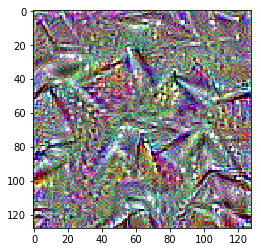

In [12]:
plt.figure()
plt.imshow(result_img[0])